In [1]:
import glob
import os
import pandas as pd
import argparse
import subprocess
import re
from IPython.core import display as ICD
from os import listdir
from multiprocessing import Pool

from shutil import rmtree
from subprocess import check_output

# Chocolate Milkshake Betaseries 


## Table of Conents:

* [FSL feat1 analysis](#second-bullet)  
* [Concatenate with fslmerge](#third-bullet)
* [Transform functionals with flirt and fslmath](#fourth-bullet)
* [Pull individual ROI timeseries by subject](#fifth-bullet)


**The Paradigm**

Functional Tasks: 

    milkshake pic, milkshake receipt, h20 pic, h20 receipt, milkshake minus h20, milkshake plus h20, rinse

Furthermore, `milkshake` is broken down into the following specifities:   
      
    HF(high fat, HS(high sugar), and respectively, LF(low fat), LS(low sugar)   

with the following relationships:  
    
    HF_HS, HF_LS, LF_HS, LF_LS



### Helper Functions
Common functions used throughout the program.

**Set Variables**  
Set common variable paths, such as the betaseries output folder, the study folder, etc...

View if any tasks are available

In [2]:
#print(os.system('echo ${FSLDIR}'))


In [3]:
data_path='/projects/niblab/experiments/chocolate_milkshake/data'
beta_series_path='projects/niblab/experiments/chocolate_milkshake/data/betaseries'

In [4]:
beta_path='/projects/niblab/experiments/chocolate_milkshake/data/betaseries'
concat_path="/projects/niblab/experiments/chocolate_milkshake/data/betaseries/niftis_concat"
keyword="LF_HS_minus_h20"


# load and set variables
beta_path='/projects/niblab/experiments/chocolate_milkshake/data/betaseries'
concat_path="/projects/niblab/experiments/chocolate_milkshake/data/betaseries/niftis_concat"
subject_folders=sorted(glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/preprocessed/sub-*'))

data_dict={}
bad_subs=[]



In [5]:
print('[INFO] EV path: {}'.format('/projects/niblab/experiments/chocolate_milkshake/data/onsets/milkshake'))

print('[INFO] Beta series analysis output path: {}'.format(beta_series_path))



[INFO] EV path: /projects/niblab/experiments/chocolate_milkshake/data/onsets/milkshake
[INFO] Beta series analysis output path: projects/niblab/experiments/chocolate_milkshake/data/betaseries


In [6]:
# view directory contents
print("[INFO] trial feat folders available, per subject")
listdir(os.path.join(data_path,
                     'preprocessed/sub-154/ses-1/analysis/beta/task-milkshakeC'))[-5:]


[INFO] trial feat folders available, per subject


['sub-154_ses-1_mkC_LF_HS_minus_h20_trial2.feat',
 'sub-154_ses-1_mkC_LF_HS_minus_h20_trial3.feat',
 'sub-154_ses-1_mkC_LF_HS_minus_h20_trial4.feat',
 'sub-154_ses-1_mkC_LF_HS_minus_h20_trial5.feat',
 'sub-154_ses-1_mkC_LF_HS_minus_h20_trial6.feat']

In [7]:

def chunks(l,n):
    return [l[i:i+n] for i in range(0, len(l), n)]

def run_multiprocess(chunks, function, poolsize=2):
    with Pool(poolsize) as p:
        return_data=p.map(function, chunks)
    return return_data

View the functional tasks:

In [8]:
choco_ev_files=glob.glob('/projects/niblab/data/eric_data/ev_files/milkshake/*.ev')
choco_evs=[x.split('/')[-1].replace('.ev',"") for x in choco_ev_files]
choco_evs=[re.sub('mk[A-Z]_', '',x) for x in choco_evs]
choco_evs=set(choco_evs)
print("[INFO] set of unique chocolate evs: \n", choco_evs)

[INFO] set of unique chocolate evs: 
 {'LF_HS_minus_h20', 'HF_HS_receipt', 'h20_receipt', 'HF_HS_minus_h20', 'rinse', 'h20_pic', 'HF_LS_receipt', 'milkshake_pic', 'HS_plus_h20', 'LF_LS_receipt', 'LF_HS_receipt'}


In [9]:
for file in glob.glob('/projects/niblab/data/eric_data/ev_files/milkshake/mkA*'):
    #print(file)
    df_temp=pd.read_csv(file, header=None)
    #ICD.display(df_temp)

*Do we want to collapse any trials(evs)?*

## FSL feat1 analysis <a class='anchor' id='second-bullet'></a>

### Make subject condition feat files (`.fsf`)

View fsf files currently available

In [10]:
listdir(os.path.join(data_path, 
                     'preprocessed/sub-154/ses-1/analysis/beta/task-milkshakeC'))[:4]



['design_files',
 'sub-154_ses-1_mkC_HF_HS_receipt_trial2.feat',
 'sub-154_ses-1_mkC_HF_LS_receipt_trial1.feat',
 'sub-154_ses-1_mkC_HF_HS_receipt_trial3.feat']

In [11]:
def make_file(sub_id, ses_id, trial_id, output_dir, task,data_dict):
    with open(os.path.join('/projects/niblab/experiments/chocolate_milkshake/data/code/beta_design.fsf'),'r') as infile:
        tempfsf=infile.read()
        #
        if not os.path.exists(os.path.join(output_dir, "design_files")):
            os.makedirs(os.path.join(output_dir, "design_files"))
        #print(output_dir)
        design_fileout = os.path.join(output_dir, "design_files/%s_%s_%s_feat1.fsf"%(sub_id, ses_id, trial_id))
        out_param = data_dict[sub_id][task]["TRIALS"]["TRIAL%s"%trial_id]["OUTPUT"]
        func_param = data_dict[sub_id][task]["FUNCRUN"]
        confound_param = data_dict[sub_id][task]["CONFOUND"]
        trial_param = data_dict[sub_id][task]["TRIALS"]["TRIAL%s"%trial_id]["TRIAL"]
        nuis_param = data_dict[sub_id][task]["TRIALS"]["TRIAL%s"%trial_id]["NUIS"]

        tempfsf = tempfsf.replace("OUTPUT", out_param)
        tempfsf = tempfsf.replace("FUNCRUN", func_param) 
        tempfsf = tempfsf.replace("CONFOUND", confound_param)
        tempfsf = tempfsf.replace("TRIAL", trial_param)
        tempfsf = tempfsf.replace("NUIS", nuis_param)

        for i in range(6):
            moco = data_dict[sub_id][task]["MOCO%i"%i]
            tempfsf = tempfsf.replace("MOCO%i"%i, moco)
        try:
            with open(design_fileout,'w') as outfile:
                outfile.write(tempfsf)
            outfile.close()
        except:
            print("BAD SUBJECT ", sub_id)
        infile.close()

        
        

In [12]:
def create_fsf(input_dir, deriv_path, ses_id):
    orig_path='/projects/niblab/bids_projects/Experiments/ChocoData/derivatives'
    ses_id=ses_id
    data_dict= {}
    # start loop -- looping through subjects
    subject_list = glob.glob(os.path.join(deriv_path, 'preprocessed', 'sub-*/%s'%ses_id))
    for sub_path in sorted(subject_list):
        #print(sub_path)
        sub_id=sub_path.split("/")[-2]
        functional_tasks = glob.glob(os.path.join(orig_path,'%s/ses-1'%sub_id, 'func/*milkshake*preproc_brain.nii.gz'))
        if sub_id not in data_dict:
            data_dict[sub_id] = {}
                
        
        for functional in functional_tasks: # SECOND LOOP -- looping through RUNS
            #print(sub_id)
            task=functional.split("/")[-1].split("_")[2].split("-")[1]
            #print(task)
            analysis_folder=os.path.join(deriv_path, 'preprocessed/%s/%s'%(sub_id,ses_id), "analysis")
            #print(analysis_folder)
            output_dir = os.path.join(analysis_folder, 'beta/task-%s'%task)
            
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            
            confound_file = os.path.join(orig_path, "%s/ses-1"%sub_id, "func/motion_assessment/%s_%s_task-%s_bold_space-MNI152NLin2009cAsym_preproc_brain_confound.txt"%(sub_id,ses_id, task))
                
            data_dict[sub_id][task] = {
                "TRIALS" : { },
                "CONFOUND" : confound_file,
                "FUNCRUN" : functional
              }           
            
            for i in range(6):
                motcor=os.path.join(orig_path, "%s/ses-1"%sub_id, 'func','motion_assessment', 'motion_parameters','%s_%s_task-%s_moco%s.txt'%(sub_id,ses_id, task,i))
                data_dict[sub_id][task]['MOCO%i'%i] = motcor
            
            
            subj_trials = sorted(glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/evs/trials/%s*trial*.txt'%task.replace('milkshake', 'mk')))
            
            #print(subj_trials)
            
            
            if not subj_trials:
                pass
            else:
                for trial_file in subj_trials:
                    _id = sub_id.split("-")[1]
                    _id = _id[1:]
                    trial_id = trial_file.split("/")[-1].split(".")[0]
                    #print(trial_id)
                    nuis_file = os.path.join('/projects/niblab/experiments/chocolate_milkshake/data/evs/nuis', '%s.txt'%trial_id.replace('trial', 'nuis'))
                    #print(nuis_file)
                    fileout = os.path.join(output_dir, "%s_%s_%s"%(sub_id, ses_id,trial_id))
                    #print(fileout)
                    data_dict[sub_id][task]["TRIALS"]["TRIAL%s"%trial_id] = {"TRIAL" : trial_file, "NUIS": nuis_file, "OUTPUT" : fileout}
                    #make_file(sub_id, ses_id, trial_id,output_dir, task, data_dict)
                    
    print("[INFO] completed making fsl feat1 files.")               
    return(data_dict)



In [13]:
def fsl_feat1():
    deriv_path='/projects/niblab/experiments/chocolate_milkshake/data/bids/derivatives'
    ses_id='ses-1'
    input_dir = '/projects/niblab/experiments/chocolate_milkshake'
    data_dict=create_fsf(input_dir, deriv_path,ses_id)
    
fsl_feat1()

[INFO] completed making fsl feat1 files.


**Run Slurm Jobs**

In [145]:
subject_list =  [x.split("/")[-2].split("-")[1].strip('0') for x in glob.glob(os.path.join('/projects/niblab/bids_projects/Experiments/ChocoData/derivatives', 'sub-*/ses-1'))]
subject_list[:5]

['1', '4', '5', '9', '11']

In [12]:
def slurm_by_file(subject,keyword):
    fsfs=glob.glob(os.path.join('/projects/niblab/experiments/chocolate_milkshake/data/bids/derivatives/preprocessed/{}/ses-1/analysis/beta/task*/design_files/*{}*.fsf'.format(subject, keyword)))
    for fsf in fsfs:
        slurm_cmd = "sbatch /projects/niblab/experiments/chocolate_milkshake/data/code/beta_by_file.job {}".format(fsf)
        #print('[INFO] submitted: \n', slurm_cmd)
        #os.system(slurm_cmd)
    
        

Submit slurm jobs by running fsf files individually:

In [104]:
subject_ids=[x.split('/')[-2] for x in glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/bids/derivatives/preprocessed/*/ses-1')]
keyword="pic"
for subject in subject_ids:
    #print(subject)
    slurm_by_file(subject, keyword)

print('[INFO] submitted slurm jobs.')
    

[INFO] submitted slurm jobs.


In [11]:
!squeue -u nbytes


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [28]:
#listdir('/projects/niblab/experiments/chocolate_milkshake/data/bids/derivatives/preprocessed/sub-113/ses-1/analysis/beta/task-milkshakeB')



## Setup data dictionary

In [14]:

for folder in subject_folders:
    subject_id=folder.split("/")[-1]
    #print(os.path.join(folder,'ses-1/analysis/beta/*.feat'))
    tasks=glob.glob(os.path.join(folder,'ses-1/analysis/beta/*'))
    #print(tasks)
    if not tasks:
        bad_subs.append(subject_id)
    else:
        if subject_id not in data_dict:
            data_dict[subject_id]={}
        for task_folder in tasks:
            #print(task_folder)
            task=task_folder.split("/")[-1].split('.')[0]
            #print(task)
            if task not in data_dict[subject_id]:
                data_dict[subject_id][task]={}
            pes=glob.glob(os.path.join(task_folder, '*.feat'))
            data_dict[subject_id][task]=pes
       
    
    

In [15]:
for subject in data_dict:
    #print("[INFO] ", subject)
    for task in data_dict[subject]:
        #print("[INFO] ", task)
        dir_ct=0
        
        
        for directory in data_dict[subject][task]:
            
            if "minus" in directory:
                dir_ct+=1
        if dir_ct < 9:
            print("[INFO] %s %s"%( subject, task))
            print(dir_ct)
        #print(dir_ct)
            

## Concatenate (fslmerge) data <a class='anchor' id='third-bullet'></a>  
`fslmerge : concatente image files into a single output.`   
  
In this step we use the `fslmerge` command to combine the `pe.nii.gz` files by subject of the same condition.  




In [24]:

def merge_files(subject_list, data_dict=data_dict,keyword=keyword):

    for subject_id in subject_list:
        for task in data_dict[subject_id]:
            #print(task)
            feat_path='/projects/niblab/experiments/chocolate_milkshake/data/bids/derivatives/preprocessed/%s/ses-1/analysis/beta/%s/*%s*.feat/stats/pe1.nii.gz'%(subject_id, task, keyword)
            pes=glob.glob(os.path.join(feat_path))
            #print(pes)
            #print(trial)
            #filename=trial.replace(subject_id+"_", "")
            extension=task+"_%s"%keyword
            outfile = os.path.join(concat_path, "%s/%s_%s"%(keyword, subject_id, extension))
            #print(outfile)
            if not pes:
                bad_subs.append(subject_id)
            else:
                pe_str = " ".join(pes)
                fslmerge_cmd="/projects/niblab/modules/software/fsl/5.0.10/bin/fslmerge -t %s %s"%(outfile, pe_str)
                #print("[INFO] running fsl merge command...")
                #print(fslmerge_cmd, "\n")
                #os.system(fslmerge_cmd)


            

In [67]:
chunksize=10
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(subject_ids, chunksize)

#print(chunk_list)
print("[INFO] running fslmerge ....\nfslmerge -t [OUTPUT FILENAME][PE FILES]")

with Pool(5) as p:
    p.map(merge_files, chunk_list)
print("[INFO] process complete.")
print('[INFO] find images here: ',concat_path )

[INFO] chunksize: 10
[INFO] running fslmerge ....
fslmerge -t [OUTPUT FILENAME][PE FILES]
[INFO] process complete.
[INFO] find images here:  /projects/niblab/experiments/chocolate_milkshake/data/betaseries/niftis_concat


## Transform Functionals (flirt & fslmaths) <a class='anchor' id='fourth-bullet'></a> 
To use the BigBrain300 rois we need to transform the nifti task files to match the mask.
ROIs location on renci: `/projects/niblab/parcellations/chocolate_decoding_rois`   

Big Brain 300: `/projects/niblab/parcellations/chocolate_decoding_rois/old_rois/bigBrain300_atlas`
  
`flirt`: the main program that performs affine registration. The options we use here:  
* `-in`, an input  
* `-ref`, a reference volume  
* `applyxfm`, `-init` and `-out`, apply a saved transformation to a volume   

  
  
*For these usages the reference volume must still be specified as this sets the voxel and image dimensions of the resulting volume.*



In [199]:
print('[INFO] transform functionals to match the mask.')

reference_nifti='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.nii.gz'
reference_mat='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.mat'
for nii in fslmerged_files:
    
    # setup and run flirt
    nii=nii.replace('.nii.gz', '')
    out=nii+'_3mm'
    flirt_cmd="flirt -in {} -ref {} -init {} -applyxfm -out {}".format(nii, reference_nifti, reference_mat, out)
    #print('[INFO] flirt command: \n{}'.format(flirt_cmd))
    #os.system(flirt_cmd)
    
    fslmaths_cmd='fslmaths {} -thr 0.9 {}'.format(out,out)
    #print('[INFO] fslmaths command: \n{}'.format(fslmaths_cmd))
    #os.system(fslmaths_cmd)
    
print('[INFO] transformation process complete.')

    
    

[INFO] transform afunctionals to match the mask.
[INFO] transformation process complete.


In [83]:
def tranform_niftis(niftis, keyword=keyword):
    reference_nifti='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.nii.gz'
    reference_mat='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.mat'
    for nii in niftis:

        # setup and run flirt
        nii=nii.replace('.nii.gz', '')
        out=nii+'_3mm'
        flirt_cmd="flirt -in {} -ref {} -init {} -applyxfm -out {}".format(nii, reference_nifti, reference_mat, out)
        #print('[INFO] flirt command: \n{}'.format(flirt_cmd))
        #os.system(flirt_cmd)

        fslmaths_cmd='fslmaths {} -thr 0.9 {}'.format(out,out)
        #print('[INFO] fslmaths command: \n{}'.format(fslmaths_cmd))
        #os.system(fslmaths_cmd)

In [84]:

print('[INFO] transform functionals to match the mask.')
chunksize=10
# grab concatenated (fslmerge) data
keyword="LF_HS_minus_h20"
fslmerged_files=glob.glob(os.path.join(concat_path,'%s/*%s*.nii.gz'%(keyword,keyword)))
#fslmerged_files[:4]
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(fslmerged_files, chunksize)
with Pool(5) as p:
    p.map(tranform_niftis, chunk_list)
print('[INFO] transformation process complete.')


[INFO] transform functionals to match the mask.
[INFO] chunksize: 10
[INFO] transformation process complete.


### Quality Check

View fslmerge niftis avaiable

In [12]:
stim_list=listdir(os.path.join(concat_path ))#keyword))
print(stim_list)

['HF_HS_minus_h20', 'HS_plus_h20', 'LF_HS_minus_h20', 'milkshake_receipt']


In [13]:
for stim in stim_list:
    print("[INFO] STIMULUS: %s (%s files) "%(stim,len(listdir(os.path.join(concat_path, stim)))))
    #print(sorted(listdir(os.path.join(concat_path, stim))[-2:]))
    
    #get subjects 
    


[INFO] STIMULUS: HF_HS_minus_h20 (227 files) 
[INFO] STIMULUS: HS_plus_h20 (227 files) 
[INFO] STIMULUS: LF_HS_minus_h20 (227 files) 
[INFO] STIMULUS: milkshake_receipt (224 files) 


## Pull ROI timeseries  <a class='anchor' id='fifth-bullet'></a>

Pull individual rois timeseries for each subject. 

Example command:  


    fslmeants -i ~/sub-001_punish.nii.gz -o ~/3_pull_timeseries/sub-001_punish_AI_35_23_-6_asymPREPspace.nii.gz.txt -m ~/AI_35_23_-6_asymPREPspace.nii.gz



Here is the code:

In [52]:


def pull_timeseries(roi_list, bb300_path='/projects/niblab/parcellations/bigbrain300',roi_df='/projects/niblab/parcellations/bigbrain300/renaming.csv'):

    
    bad_subs=[]
    #ICD.display(roi_df)

    # load asymmetrical nifti roi files
    asym_niftis=glob.glob("/projects/niblab/parcellations/bigbrain300/MNI152Asymmetrical_3mm/*.nii.gz")

    # load roi list
    out_dir = os.path.join(beta_path, 'rois/big300')
    #print('[INFO] OUT DIRECTORY: %s \n'%out_dir)

    #roi_df.set_index("final order name", inplace=True)
    #ICD.display(roi_df)#.head())

    # run parallel job pools


    # loop through the roi file list
    #print(roi_list[:3])
    for nifti in sorted(roi_list):
        #print('[INFO] loop1')
        #print(nifti)
        subj_id = nifti.split("/")[-1].split("_")[0]
        subj_condition=nifti.split("/")[-1].split(".")[0].replace("_3mm", "")
        #print('[INFO] roi: %s %s'%(subj_id, subj_condition))

        # loop through roi reference list
        for ref_nifti in sorted(asym_niftis):
            #print('[INFO] reference roi: %s'%ref_nifti)
            roi = ref_nifti.split('/')[-1].split(".")[0]
            out_path = os.path.join(out_dir, "{}_{}.txt".format(subj_condition, roi))
            #print(roi, out_path)
            cmd='fslmeants -i {} -o {} -m {}'.format(nifti, out_path, ref_nifti)
            try:
                #cmd='fslmeants -i {} -o {} -m {}'.format(nifti, out_path, ref_nifti)
                #print("Running shell command: {}".format(cmd))
                os.system(cmd)
            except:
                bad_subs.append((subj_id, subj_condition))
        
        #print('[INFO] finished processing for %s'%subj_id)
        

    return "%s"%bad_subs

   

In [53]:
stim='HS_plus_h20'

# load roi
print("[INFO] loading roi and reference file....")

# task rois loaded
task_rois=sorted(glob.glob(os.path.join(concat_path,stim,'*sub-*_3mm.nii.gz')))
#print(task_rois[:5])
print("[INFO] {} task roi nifti files being processed.".format(len(task_rois)))

chunksize=6
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(task_rois, chunksize)
#roi_df['network']
# pull timeseries by rois --fslmeants command

def run_process(pool_size):
    print("[INFO] starting multiprocess...")
    with Pool(pool_size) as p:
        error_subjects=p.map(pull_timeseries, chunk_list)
    print("[INFO] process complete. \n[INFO] bad subjects: \t\t%s"%error_subjects)
    
pool_size=15
run_process(pool_size)

[INFO] loading roi and reference file....
[INFO] 6 task roi nifti files being processed.
[INFO] chunksize: 6
[INFO] starting multiprocess...
[INFO] process complete. 
[INFO] bad subjects: 		['[]']


**Submit process as a batch job for large datasets**  

Two files:  
- timeseries_pull.job  
- timeseries_pull.py  

*quick view of file contents below* -- note,for now paths may need to be updated directly in the scripts for your unqiue setup, flexible script in progress.

 

Batch file:

In [20]:
#!cat /projects/niblab/experiments/chocolate_milkshake/data/code/timeseries_pull.job

Python file:

In [21]:
#!cat /projects/niblab/experiments/chocolate_milkshake/data/code/timeseries_pull.py

To submit job file:  

In [25]:
!sbatch /projects/niblab/experiments/chocolate_milkshake/data/betaseries/timeseries_roi_pull.job LF_HS_minus_h20


Submitted batch job 3185257


To view job:

In [14]:
!squeue --job 3185257


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3185257     batch timeseri   nbytes  R    3:01:55      1 largemem-0-0


View all jobs:

In [24]:
!squeue -u nbytes

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


### Get timeseries roi task files 

In [14]:
# view timeseries 
listdir('/projects/niblab/experiments/chocolate_milkshake/data/betaseries/rois/big300')



['LF_HS_minus_h2O', 'HF_HS_minus_h2O', 'HS_plus_h2O', 'milkshake_receipt']

Look at single file contents:  


In [15]:
#/projects/niblab/experiments/chocolate_milkshake/data/betaseries/rois/big300/milkshake_receipt/sub-049_task-milkshakeC_bb300_MNI152Asymm3mm_001.txt

!cat /projects/niblab/experiments/chocolate_milkshake/data/betaseries/rois/big300/milkshake_receipt/sub-049_task-milkshakeC_bb300_MNI152Asymm3mm_001.txt


1.305654261  
22.92921219  
2.180785209  
7.329646152  
1.913219816  
12.33518228  
1.481388868  
26.48972737  
7.085836688  
15.88141086  
21.39033703  
17.30740555  
9.705909108  
49.65908761  
2.668380528  
2.808356385  
87.48411054  
104.7683015  
13.93522501  
36.65064512  
14.73222093  
63.62429159  
621.9953755  
3206.146965  
2860.557884  
2922.173812  
930.39091  
4743.002419  


In [21]:


# view number of subject timeseries rois created/pulled
for stim in stim_list:
    print("[INFO] %s (%s files)"%(stim, 
                                  len(glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/betaseries/rois/big300/%s/*.txt'%stim))))


[INFO] HF_HS_minus_h20 (68100 files)
[INFO] HS_plus_h20 (128929 files)
[INFO] LF_HS_minus_h20 (68100 files)
[INFO] milkshake_receipt (67200 files)


## Combine Timeseries into Matrix  <a class="anchor" id="sixth-bullet"></a>
Combine timeseries roi files into, **one file per condition per participant**  

In [16]:
subject_ids=list(data_dict.keys())
subject_ids[-3:]


['sub-150', 'sub-151', 'sub-154']

### Combine Timeseries into a Matrix, per subject by condition

Loop through subject ids and combine in matrix

What conditions are available to concat?

In [119]:
listdir(os.path.join(beta_path, 'rois/big300'))

['LF_HS_minus_h2O', 'HF_HS_minus_h2O', 'HS_plus_h2O', 'milkshake_receipt']

Do we have any output already?

In [79]:
listdir(os.path.join(beta_path, 'subject_matrices'))


['HS_plus_h2O', 'HF_HS_minus_h2O', 'milkshake_receipt']

Set the task variable we want to process, and....

In [75]:

def timeseries_concat(subject_ids,verbose=False):
    
    for subject_id in subject_ids:
        tasks=list(data_dict[subject_id].keys())
        for task in tasks:

            #print(subject_id, task, stim)
            #print(os.path.join(beta_path, 'rois/big300/%s'%stim))
            # get roi texts for subject / condition
            roi_files = glob.glob(os.path.join(beta_path, 'rois/big300/%s/%s*%s*.txt'%(stim, subject_id,task)))

            df_lst=[]
            #print(roi_files)
            try:
                for txt in roi_files: 
                    #print(txt)
                    df_temp = pd.read_csv(txt, sep="\n", header=None)
                    #print(df_temp)
                    df_lst.append(df_temp)
                #print(subject_id, task, len(df_lst))

                df_concat= pd.concat(df_lst, axis=1, sort=False)
                #print(df_concat)

                # write output file 
                
                if not os.path.exists(os.path.join(beta_path,'subject_matrices/%s'%stim)):
                    if verbose==True:
                        print('[INFO] making ',os.path.join(beta_path,'subject_matrices/%s'%stim))

                    os.makedirs(os.path.join(beta_path,'subject_matrices/%s'%stim))
                outfile=os.path.join(beta_path,
                                     'subject_matrices/%s/%s_%s_%s.txt'%(stim,subject_id,task, stim))
                if verbose==True:
                    print('[PROCESSING] making file %s....'%outfile)

                df_concat.to_csv(outfile, header=None, index=None, sep='\t')
            except:
                pass
                error_subjects.append((subject_id,task))

    #if error_subjects: print(error_subjects)
    return error_subjects;


    
    

Run parallel process:

In [80]:
stim='LF_HS_minus_h2O'
print("[INFO] combining trial condition into one timeseries matrix for stimulus %s..."%stim)

subject_ids=list(data_dict.keys())

error_subjects=[]
chunksize=15
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(subject_ids, chunksize)

def run_process(pool_size):
    print("[INFO] starting multiprocess...")
    with Pool(pool_size) as p:
        error_subjects=p.map(timeseries_concat, chunk_list)
    
pool_size=15
run_process(pool_size)
print("[INFO] completed process.")
#print("[INFO] process complete. \n[INFO] bad subjects: \t\t%s"%error_subjects)



[INFO] combining trial condition into one timeseries matrix for stimulus LF_HS_minus_h2O...
[INFO] chunksize: 15
[INFO] starting multiprocess...
[INFO] completed process.


#### Quality check

View error subjects

In [81]:
if not error_subjects:
    print("[INFO] no errors found.")
else:
    print("[INFO] subjects with errors: \t%s"%error_subjects)


[INFO] no errors found.


Quick view of new files:

In [82]:
output_path=os.path.join(beta_path,
                        'subject_matrices/%s'%stim)
print('[INFO] looking at folder: \n\t%s'%output_path)
print('[INFO] %s files found.'%len(glob.glob(os.path.join(output_path, '*.txt'))))

[INFO] looking at folder: 
	/projects/niblab/experiments/chocolate_milkshake/data/betaseries/subject_matrices/LF_HS_minus_h2O
[INFO] 227 files found.


In [83]:
sorted(listdir('/projects/niblab/experiments/chocolate_milkshake/data/betaseries/subject_matrices/%s'%'milkshake_receipt'))[-6:]



['sub-150_task-milkshakeB-receipt.txt',
 'sub-150_task-milkshakeC-receipt.txt',
 'sub-151_task-milkshakeB-receipt.txt',
 'sub-151_task-milkshakeC-receipt.txt',
 'sub-154_task-milkshakeA-receipt.txt',
 'sub-154_task-milkshakeC-receipt.txt']

In [84]:
# view number of subject timeseries rois created/pulled
for stim in listdir(os.path.join(beta_path, 'subject_matrices')):
    print("[INFO] %s (%s files)"%(stim, 
                                  len(glob.glob(os.path.join(beta_path, 'subject_matrices/%s/*.txt'%stim)))))


[INFO] HS_plus_h2O (216 files)
[INFO] HF_HS_minus_h2O (227 files)
[INFO] LF_HS_minus_h2O (227 files)
[INFO] milkshake_receipt (224 files)


In [86]:
#!cat /projects/niblab/experiments/chocolate_milkshake/data/betaseries/subject_matrices/HS_plus_h2O/sub-147_task-milkshakeB_HS_plus_h2O.txt



In [85]:

#!cat /projects/niblab/experiments/chocolate_milkshake/data/betaseries/subject_matrices/milkshake_receipt/sub-150_task-milkshakeB-receipt.txt


## Make Functional Connectivity Matrices

In [115]:
#!pip install nilearn

In [16]:
import seaborn as sns
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from matplotlib import pyplot as plt
from nilearn import plotting
from nilearn.plotting import plot_connectome


In [69]:
stim="milkshake_receipt"
example_file=timeseries_files[0]
cmap="BuPu"
stim_list=listdir('/projects/niblab/experiments/chocolate_milkshake/data/betaseries/rois/big300')



In [72]:
# make fc matrices

"""
  Takes timeseries matrices and makes functional connectivity matrices with nilearns ConnectivityMeasure object.
  We pass a condition, or named here the 'file_suffix', to identify our individual task files,
  and we pass the number of extracted regions.
  Outputs: makes subject FCMs, plots FCMs
  Returns: a function correlation dictionary as well as individual subject list

  ** Extensions: plotting, save individual FCMs...
"""
def makeFCM(cmap, timeseries, stim, n_regions_extracted=300, functionals=None):
    #print('[INFO] making functional connectivity matrices with nilearn ConnectivityMeasure object...')
    fc_corr_dict = {}
    
    subj_list=[]
    bad_subjects=[]
    correlations = []
    # Initializing ConnectivityMeasure object with kind='correlation'
    connectome_measure = ConnectivityMeasure(kind='correlation')
    #print(timeseries)
    #print('[INFO] stim: ', stim)
    for subj_timeseries in sorted(timeseries):
        #print(subj_timeseries)
        subj_id=subj_timeseries.split("/")[-1].split("_")[0]
        if subj_id not in fc_corr_dict:
            fc_corr_dict[subj_id] = {}
        if subj_id not in subj_list:
            subj_list.append(subj_id)
        if stim in subj_timeseries:
            filename = "%s_task-%s.txt"%(subj_id, stim)
            try:
                # we load the text file timeseries into an array 
                np_arr = np.loadtxt(subj_timeseries)
                #print(np_arr)

                # call fit_transform from ConnectivityMeasure object
                correlation = connectome_measure.fit_transform([np_arr])
                #print('[INFO] CORRELATION: ', correlation)
                
                # saving each subject correlation to correlations
                fc_corr_dict[subj_id][stim] = correlation
                correlations.append(correlation)
                
                # plot subject correlation matrix
                #sns.heatmap(correlation, annot=True)
                # save text
                #np.savetxt('/content/'+filename, correlation.transpose(2,0,1).reshape(3,-1))
            except:
                bad_subjects.append(subj_id)
                pass
    try:
        # Mean of all correlations
        mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted, n_regions_extracted)



        ## plotting
        #print('[INFO] Plot of the mean functional connectivity matrix: \n')
        title = 'Correlation between %d regions, condition %s'%(n_regions_extracted,stim)
        # First plot the matrix
        print('[INFO] %s'%title)
        display = plotting.plot_matrix( mean_correlations,figure=(9, 7),
                                       colorbar=True, cmap=cmap) #, tri='lower')
        plt.show()
        print("\n")
        if bad_subjects:
            print('[INFO] bad subjects for %s....\t%s'%(stim,bad_subjects))

        # Then find the center of the regions and plot a connectome
        #regions_img = regions_extracted_img
        #coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

        #plotting.plot_connectome(mean_correlations, coords_connectome,
                              #edge_threshold='90%', title=title)"""

        #return fc_corr_dict, subj_list;
    except:
        pass



  

Run Process

[INFO] making functional connectivity matrices (FCM)...
[INFO] Correlation between 300 regions, condition LF_HS_minus_h2O


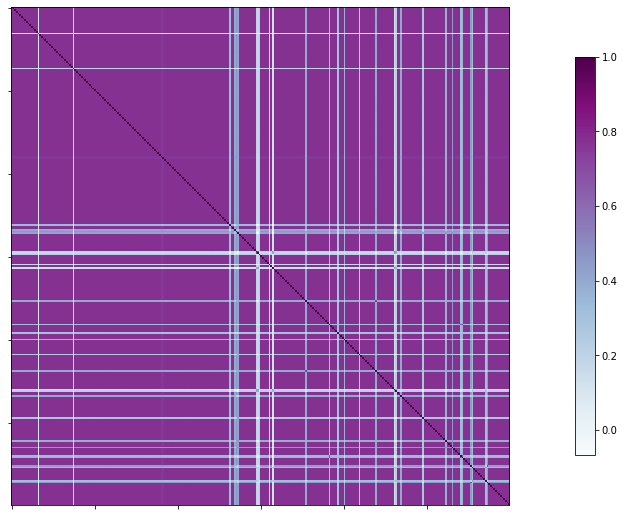



[INFO] Correlation between 300 regions, condition HF_HS_minus_h2O


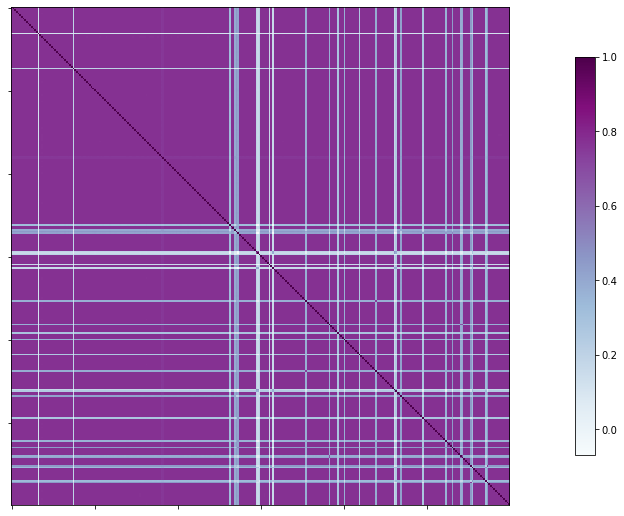



[INFO] Correlation between 300 regions, condition HS_plus_h2O


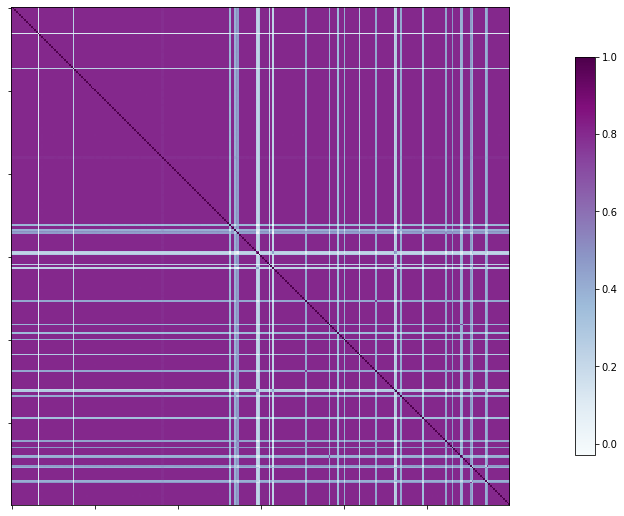



[INFO] Correlation between 300 regions, condition milkshake_receipt


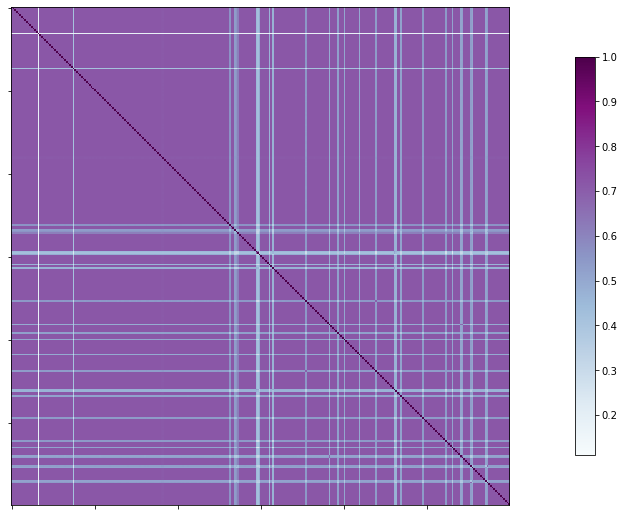

In [73]:
print("[INFO] making functional connectivity matrices (FCM)...")
for stim in stim_list:
    timeseries_files=glob.glob(os.path.join(beta_path,'subject_matrices/%s/*.txt'%stim))

    makeFCM(cmap, timeseries_files, stim, save_files)
    
    